# 人工知能とソフトコンピューティング 第6回 CNN 演習


## 分析対象となるデータの準備
ここではMNISTの手書き数字画像分類を行う

In [4]:
base_path = '.'

### ステップ1
必要なライブラリをインポートする  


In [5]:
from pathlib import Path # ファイルパスの取り扱い
import matplotlib.pyplot as plt # グラフ描画
import numpy as np # 数値取扱い
import pandas as pd # ファイル読み込み，データフレーム
from sklearn.model_selection import train_test_split # 訓練データとテストデータの分割
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as L
from pytorch_lightning.utilities.model_summary import ModelSummary
from torchmetrics import Accuracy
from torchvision import transforms # 画像変換ライブラリ
from torchvision.datasets import MNIST # MNISTのデータ

### ステップ2
MNISTデータセット（手書きの数字と正解ラベルのセット）を分類の対象とし，訓練データとテストデータに分割  
※ 訓練データの一部は，訓練中の評価データとして用いる
* train_images, train_labels: ニューラルネットワークを訓練するのに必要な訓練データ（画像と正解ラベル）
* validation_images, validation_labels: ニューラルネットワークの訓練中に用いる評価データ（画像と正解ラベル）
* test_images, test_labels: 学習済みのニューラルネットワークに対するテストデータ（画像と正解ラベル）
  
データを読み込む際に，transforms.ToTensor() を使って画像の白黒の濃淡を0～1の範囲に正規化している

In [6]:
#訓練データ
train_dataset = MNIST(root=Path(base_path, 'data'),
                      train=True,
                      transform=transforms.ToTensor(),
                      download = True)
#検証データ
test_dataset = MNIST(root=Path(base_path, 'data'),
                      train=False,
                      transform=transforms.ToTensor(),
                      download = True)

# 60000枚の学習用ベースデータを 48000枚（訓練用データ）と12000枚（訓練中の評価用データ）に分割
# 乱数シードを固定して毎回同じ分割になるようにする
generator = torch.Generator().manual_seed(0)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

# 個々の画像データの形状は、枚数x色チャネル数×横ピクセル数×縦ピクセル数
# 色チャネルは1次元（白黒の濃淡 0～255），RGBデータの場合は3次元を用いる
# 画像の大きさは 28×28
# 白黒の濃淡は0～1の範囲に正規化されている

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 3.39MB/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 168kB/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.00MB/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



### ステップ3
データ中の画像と正解ラベルをいくつか表示して確認する

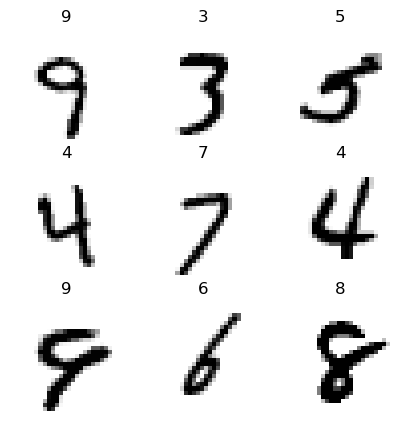

In [7]:
plt.figure(figsize = (5, 5)) # 図オブジェクト生成（サイズ 5インチ×5インチ）

for i in range(9):
    image, label = train_dataset[i]
    subplot = plt.subplot(3, 3, i + 1) # 図の中に3×3の区画を作り，その i+1番目の区画を指定
    # squeezeは[1, x, y] のTensorを[x,y]のTensorに変換する
    plt.imshow(image.squeeze(), cmap = plt.cm.binary) # 画像を白黒で表示
    plt.title(label) # タイトルはデータが持つ正解ラベルとする
    plt.axis("off")

## ニューラルネットワーク（CNN）の構造定義

### ステップ4
次の構造を持つニューラルネットワークのアーキテクチャ（Sequential：逐次構造）を定義
* Conv2D: 2次元畳み込み層
* MaxPooling2D: 2次元最大プーリング層
* Conv2D: 2次元畳み込み層
* MaxPooling2D: 2次元最大プーリング層
* Conv2D: 2次元畳み込み層
* Flatten: 1次元へのデータ変換層
* Dense: 全結合層

次の訓練方法を設定
* 重み計算の最適化アルゴリズム Adam（Adaptive Moment Estimation）
* 損失関数（モデルと期待との差異を評価する尺度）CrossEntropyLoss（クロスエントロピー損失）
* 訓練中に訓練データと評価データに対して取得する値 accuracy （分類精度）

In [8]:
class MNISTCNN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters() # ハイパーパラメータを保存
        self.example_input_array = torch.zeros((1, 1, 28, 28)) # 枚数×色チャネル数×横ピクセル数×縦ピクセル数

        # 出力クラス数（数字 0～9 の10クラス分類）
        self.num_classes = 10 
        # CNNモデル定義
        self.model = nn.Sequential(
            # Conv2d: 2次元の畳み込み層 フィルタ（出力）数 16，フィルタサイズ 3x3，ストライド 1x1，パディング なし
            #         1x28x28 のデータを入力し，3x3 のフィルタを 1x1 ずつスライドさせる
            #         3x3 のフィルタを 16枚用意して同じデータに適用する
            #         結果として，16x26x26 のデータを出力
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(), # 活性化関数 ReLU
            #
            # MaxPool2d: 2次元の最大プーリング層　プールサイズ 2x2，ストライド 2x2，パディング なし
            #               前段の Conv2d層から 16x26x26 のデータを入力
            #               26x26 の行列を 2x2 の部分 13x13 個に分割，1つの部分に含まれる 4つの数のうち最大値を出力
            #               結果として，16x13x13 のデータを出力
            #               MaxPooling2d の代わりに AvgPool2d を用いると平均プーリング層を定義できる
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            #
            # Conv2D: 2次元の畳み込み層 フィルタ数 32，フィルタサイズ 3x3，ストライド 1x1，パディング なし
            #         前段の MaxPool2d層から 16x13x13 のデータを入力，3x3 のフィルタをスライド
            #         3x3のフィルタを 32枚用意して，32x11x11 のデータを出力
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(), # 活性化関数 ReLU
            #
            # MaxPooling2D: 2次元の最大プーリング層
            #               前段の Conv2d層から 32x11x11 のデータを入力，2x2の最大値を取る
            #               結果として 32x5x5 のデータを出力
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # MaxPooling層
            #
            # Conv2D: 2次元の畳み込み層 フィルタ数 64，フィルタサイズ 3x3，ストライド 1x1，パディング なし
            #         前段の MaxPooling2D層から 32x5x5 のデータを入力，3x3 のフィルタをスライド
            #         3x3のフィルタを 64枚用意して，64x3x3 のデータを出力
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(), # 活性化関数 ReLU
            #
            # MaxPooling2D: 2次元の最大プーリング層
            #               前段の Conv2D層から 64x3x3 のデータを入力，2x2の最大値を取る（終端の余りデータは無視）
            #               結果として 64x1x1 のデータを出力
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # MaxPooling層
            #
            # Flatten: 1次元データへの変換層
            #          前段の MaxPooling層から 64x1x1 のデータを入力
            #          64個の値のリストを出力
            nn.Flatten(), # Flatten層
            #
            # Linear: 全結合のニューロン層 ユニット（出力）数 10，活性化関数 Softmax
            #        前段の Flatten層から64個の値リストを入力
            #        num_classes 個のユニットから値を出力
            nn.Linear(in_features=64, out_features=self.num_classes), # 全結合層
        )

        # 損失関数: クロスエントロピー損失関数（多クラス分類用）
        self.criterion = nn.CrossEntropyLoss()
        
        # 評価指標: Kerasのmetrics=['accuracy'] に対応
        self.train_acc = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=self.num_classes)

    def forward(self, x):
        # 順伝播でモデルの出力を計算
        return self.model(x)

    def configure_optimizers(self):
        # オプティマイザ: Adam (デフォルトの学習率 0.001)
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001) # デフォルトの学習率を設定
        return optimizer

    def training_step(self, batch, batch_idx):
        # 訓練データのバッチを使って損失を計算
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # 損失と精度を記録
        preds = torch.argmax(logits, dim=1)
        self.train_acc(preds, y)
        
        # on_epoch=True でエポック終了時に平均値を記録
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_accuracy', self.train_acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # 検証データのバッチを使って損失を計算(training_stepと同様だが戻り値は不要)
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.val_acc(preds, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', self.val_acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        # テストデータのバッチを使って損失を計算(training_stepと同様だが戻り値は不要)
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.test_acc(preds, y)
        
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy', self.test_acc, on_step=False, on_epoch=True)


### ステップ5
定義したアーキテクチャの概要を確認  
モデル定義の行（model）およびモデルの要素(model.X)を見て、入出力関係（大きさ，次元数）に設計との不一致や層間の不整合がないかを確認する
* Type: レイヤの種類
* Params: 学習により決定するパラメータ（重み）の数
* In sizes: 入力データの形式
* Out sizes: 出力データの形式

In [9]:
ModelSummary(MNISTCNN(), max_depth=-1)

   | Name      | Type               | Params | Mode  | In sizes        | Out sizes      
----------------------------------------------------------------------------------------------
0  | model     | Sequential         | 23.9 K | train | [1, 1, 28, 28]  | [1, 10]        
1  | model.0   | Conv2d             | 160    | train | [1, 1, 28, 28]  | [1, 16, 26, 26]
2  | model.1   | ReLU               | 0      | train | [1, 16, 26, 26] | [1, 16, 26, 26]
3  | model.2   | MaxPool2d          | 0      | train | [1, 16, 26, 26] | [1, 16, 13, 13]
4  | model.3   | Conv2d             | 4.6 K  | train | [1, 16, 13, 13] | [1, 32, 11, 11]
5  | model.4   | ReLU               | 0      | train | [1, 32, 11, 11] | [1, 32, 11, 11]
6  | model.5   | MaxPool2d          | 0      | train | [1, 32, 11, 11] | [1, 32, 5, 5]  
7  | model.6   | Conv2d             | 18.5 K | train | [1, 32, 5, 5]   | [1, 64, 3, 3]  
8  | model.7   | ReLU               | 0      | train | [1, 64, 3, 3]   | [1, 64, 3, 3]  
9  | model.8   

## CNNの訓練

### ステップ6
モデルに訓練データを投入し，ネットワークの「重み」を計算
* 訓練データ（画像と正解ラベル）
* エポック数：10
* バッチサイズ：32
* 訓練結果の評価データ（画像と正解ラベル）
* 訓練の履歴を記録

バッチサイズで訓練データを分割し，すべての訓練データに対して繰り返しパラメータを最適化するまでの処理が1エポック  
訓練データの数 / バッチサイズ で 1エポックでの繰り返し数が決まる  
この例の場合，訓練データ数 48000枚でバッチサイズ 32 なので，1エポックにつき1500回の重み計算の繰り返しが行われる，それをエポック数（10）回繰り返す  
バッチサイズとエポック数はモデルの性能に影響を与える

In [10]:
epochs = 10 # エポック数
batch_size = 32 # バッチサイズ

# 1. データローダーとモデルのインスタンス化

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

mnist_cnn = MNISTCNN()

# 訓練履歴を保存するフォルダ
log_folder = Path(base_path, "logs")

# CNNモデルの学習
checkpoint_callback_cnn = L.callbacks.ModelCheckpoint(
    save_last=True,
)
cnn_logger = L.loggers.CSVLogger(log_folder, name='cnn')
cnn_trainer = L.Trainer(
    max_epochs=epochs,
    logger=cnn_logger,
    callbacks=[checkpoint_callback_cnn],
    deterministic=True,
    enable_progress_bar=True
)
cnn_trainer.fit(mnist_cnn, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
checkpoint_path = checkpoint_callback_cnn.last_model_path

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params | Mode  | In sizes       | Out sizes
--------------------------------------------------------------------------------------
0 | model     | Sequential         | 23.9 K | train | [1, 1, 28, 28] | [1, 10]  
1 | criterion | CrossEntropyLoss   | 0      | train | ?              | ?        
2 | train_acc | MulticlassAccuracy | 0      | train | ?              | ?        
3 | val_acc   | MulticlassAccuracy | 0      | train | ?              | ?        
4 | test_acc  | MulticlassAccuracy | 0      | train | ?              | ?        
--------------------------------------------------------------------------------------
23.9 K    Trainable params
0         Non-trainable params
23.9 K    Total params
0.096     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 1500/1500 [00:38<00:00, 38.68it/s, v_num=0, val_loss=0.0674, train_loss=0.026] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1500/1500 [00:38<00:00, 38.64it/s, v_num=0, val_loss=0.0674, train_loss=0.026]


### ステップ7
訓練履歴（精度，損失）の確認
* 訓練用データに対する分類の精度と評価用データに対する分類の精度
* 訓練用データに対する損失と評価用データに対する損失

これらのエポック毎の記録が lightning_logs フォルダに保存されているので，読み込んでグラフに描画することで，学習が進むにつれてどのように変化したかを把握することができる 

In [11]:
def load_history(log_path):
    log_file = Path(log_path, "metrics.csv")
    history = pd.read_csv(log_file)
    train_history = history.dropna(subset=['train_loss']).reset_index(drop=True) 
    val_history = history.dropna(subset=['val_loss']).reset_index(drop=True)
    return train_history, val_history

記録から学習が進むにつれてどのように変化したかをグラフに描画して把握するための関数を定義

In [12]:
def show_accuracy_and_loss_graphs(train_history, val_history, epochs, epoch_from = 1): # 訓練履歴（精度・損失）を描画する関数
    training_accuracies = train_history["train_accuracy"] # 訓練用データに対する精度
    validation_accuracies = val_history["val_accuracy"] # 評価用データに対する精度
    training_losses = train_history["train_loss"] # 訓練用データに対する損失
    validation_losses = val_history["val_loss"] # 評価用データに対する損失
    
    epochs_range = range(epoch_from, epochs + 1) # 1 から epochs までの描画範囲を指定
    figure = plt.figure(figsize = (10, 5))
    subplot = plt.subplot(1, 2, 1)
    subplot.plot(epochs_range, training_accuracies, label = "Training Accuracy") # 訓練用データに対する精度のグラフ描画
    subplot.plot(epochs_range, validation_accuracies, label = "Validation Accuracy") # 評価用データに対する精度のグラフ描画
    subplot.set_xlabel("epochs")
    subplot.legend()
    plt.title("Training and Validation Accuracy")
    subplot = plt.subplot(1, 2, 2)
    subplot.plot(epochs_range, training_losses, label = "Training Loss") # 訓練用データに対する損失のグラフ描画
    subplot.plot(epochs_range, validation_losses, label = "Validation Loss") # 評価用データに対する損失のグラフ描画
    subplot.set_xlabel("epochs")
    subplot.legend()
    plt.title("Training and Validation Loss")
    plt.show()

### ステップ8
履歴の表示（ステップ7で定義した関数を使用）

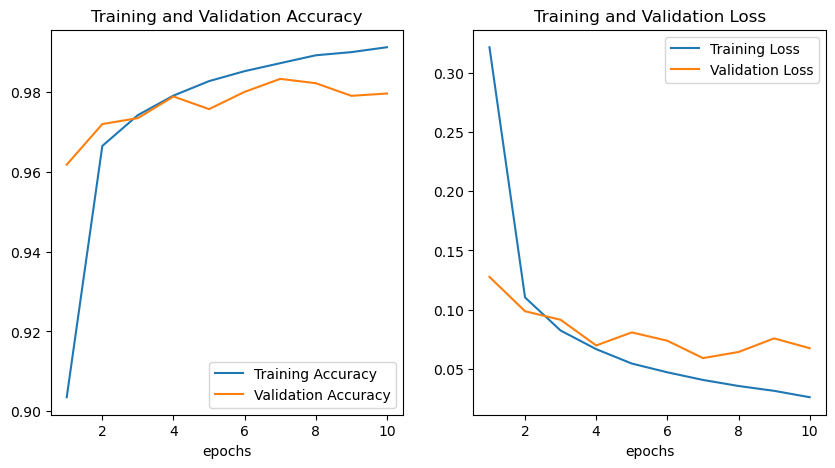

In [13]:
log_path = Path(log_folder, "cnn", f"version_{cnn_trainer.logger.version}")
cnn_train_history, cnn_val_history = load_history(log_path)
show_accuracy_and_loss_graphs(cnn_train_history, cnn_val_history, epochs)

## 訓練済みのCNNの読み込み

### ステップ9
モデルの追加訓練
* 復元されたモデルをさらに（保存された時点から）訓練する
* 追加訓練済みのモデルは（必要に応じて）保存しても良い

In [14]:
epochs_restored = 5
batch_size_restored = 32

# 1. データとモデルのインスタンス化

train_dataloader_restored = DataLoader(
    train_dataset,
    batch_size=batch_size_restored,
    shuffle=True
)

val_dataloader_restored = DataLoader(
    val_dataset,
    batch_size=batch_size_restored,
    shuffle=False
)


# 2. 訓練履歴を記録するロガーと訓練方法の設定
# 保存前のモデルと同じログフォルダを指定すると，新しいバージョンで訓練履歴が追加されて保存されます
checkpoint_restored_callback_cnn = L.callbacks.ModelCheckpoint(
    save_last=True,
)
cnn_restored_logger = L.loggers.CSVLogger(log_folder, name='cnn')
cnn_trainer_restored = L.Trainer(
    max_epochs=epochs_restored,
    logger=cnn_restored_logger,
    callbacks=[checkpoint_restored_callback_cnn],
    enable_progress_bar=True
)

# 3. 訓練開始

# 追加訓練するモデルを読み込む
restored_model = MNISTCNN.load_from_checkpoint(checkpoint_path=checkpoint_path)

cnn_trainer_restored.fit(restored_model, 
                         train_dataloaders=train_dataloader_restored,
                         val_dataloaders=val_dataloader_restored)
checkpoint_path = checkpoint_restored_callback_cnn.last_model_path
# 追加学習履歴を表示したい場合はこの下の行を実行する
#log_path = Path(log_folder, "cnn", f"version_{cnn_trainer_restored.logger.version}")
#cnn_restored_train_history, cnn_restored_val_history = load_history(log_path)
#show_accuracy_and_loss_graphs(cnn_restored_train_history, cnn_restored_val_history, epochs_restored)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params | Mode  | In sizes       | Out sizes
--------------------------------------------------------------------------------------
0 | model     | Sequential         | 23.9 K | train | [1, 1, 28, 28] | [1, 10]  
1 | criterion | CrossEntropyLoss   | 0      | train | ?              | ?        
2 | train_acc | MulticlassAccuracy | 0      | train | ?              | ?        
3 | val_acc   | MulticlassAccuracy | 0      | train | ?              | ?        
4 | test_acc  | MulticlassAccuracy | 0      | train | ?              | ?        
--------------------------------------------------------------------------------------
23.9 K    Trainable params
0         Non-trainable params
23.9 K    Total params
0.096     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 1500/1500 [00:37<00:00, 40.18it/s, v_num=1, val_loss=0.0656, train_loss=0.0159]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1500/1500 [00:37<00:00, 40.14it/s, v_num=1, val_loss=0.0656, train_loss=0.0159]


## 分類タスクの実行

### ステップ10
訓練したモデルにテスト用データを与えて評価する
* ここではファイルから読み込んだモデル（restored_model）をcnn_trainer経由で使用
* 返値は評価結果（予測精度と損失の値）

In [15]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=len(test_dataset) # 全データを一括で評価する
)
print(cnn_trainer_restored.test(restored_model, dataloaders=test_dataloader))

c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9830999970436096     │
│         test_loss         │    0.07176331430673599    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.07176331430673599, 'test_accuracy': 0.9830999970436096}]


### ステップ11
訓練したモデルにテスト用データを与えて分類を実行する
* ここではファイルから読み込んだモデル（restored_model）をcnn_trainer_restored経由で使用
* 返値は予測結果（ニューラルネットワークの出力ベクトル）

In [16]:
test_images, test_labels = next(iter(test_dataloader)) # 画像とラベルをTensorで取得
probs = cnn_trainer_restored.predict(dataloaders=DataLoader(test_images, batch_size=len(test_dataset)))
predictions = torch.cat(probs, dim=0) # リストprobの要素を結合して1つのTensorにする
predictions = nn.functional.softmax(predictions, dim=1) # 各クラスの予測値の合計が1になるようにする（確率に変換）

c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:149: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs\cnn\version_1\checkpoints\epoch=4-step=7500.ckpt
Loaded model weights from the checkpoint at logs\cnn\version_1\checkpoints\epoch=4-step=7500.ckpt
c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.94it/s]


### ステップ12
予測した結果をグラフに表示する関数を定義
* 画像
* 正解ラベル
* 分類結果（各数字に分類される確率）
の引数を与え，それぞれを並べて表示

In [17]:
def show_prediction_result(image, correct, result):
    figure = plt.figure(figsize = (6, 3))
    subplot = plt.subplot(1, 2, 1)
    plt.imshow(image, cmap = plt.cm.binary)
    plt.title("correct label = {}".format(correct))
    plt.axis("off")
    subplot = plt.subplot(1, 2, 2)
    plt.bar(range(len(result)), result)
    plt.xticks(range(len(result)), range(len(result)))
    plt.ylim(0, 1)
    plt.title("probabilites")
    plt.show()

### ステップ13
予測結果が正しい例，異なっている例を num_examples だけ取り出して表示
* どのような間違いが起こっているかを確認


正しく分類された画像の例


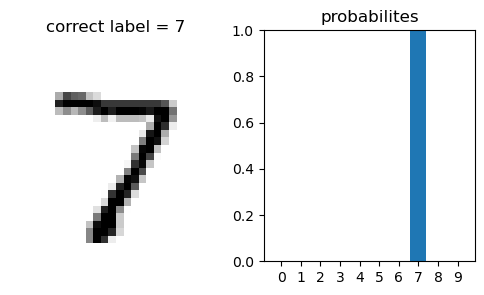

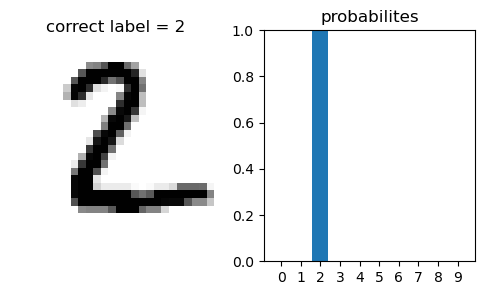

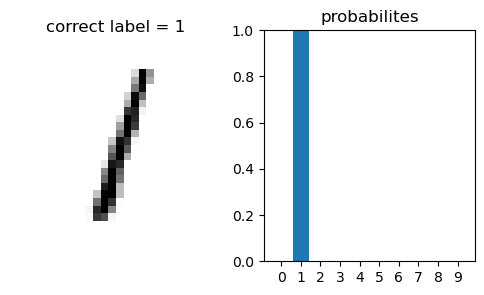

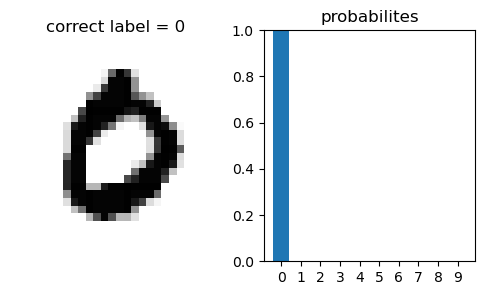

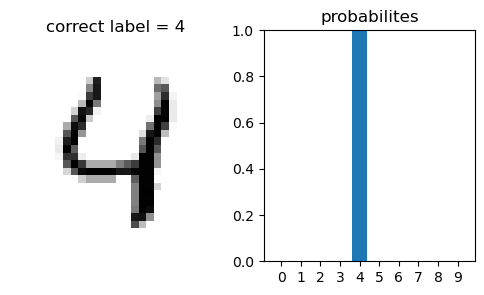

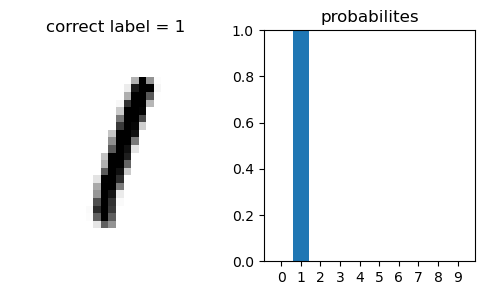


誤って分類された画像の例


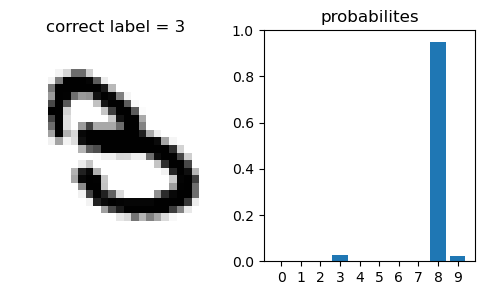

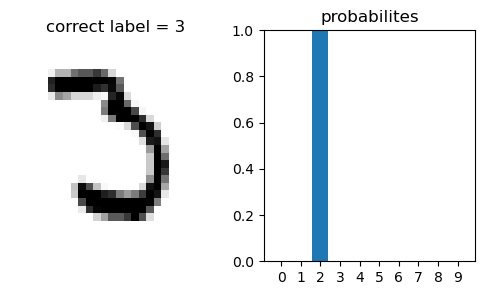

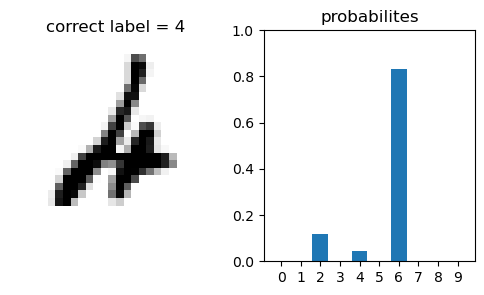

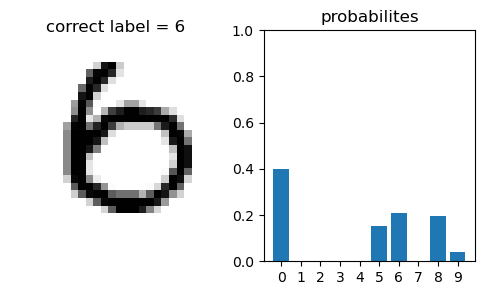

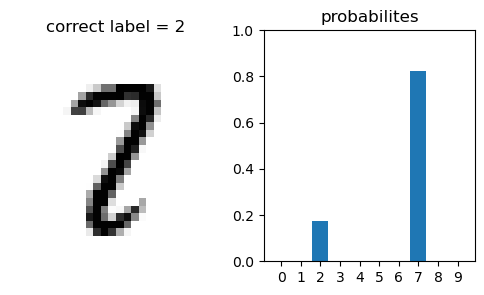

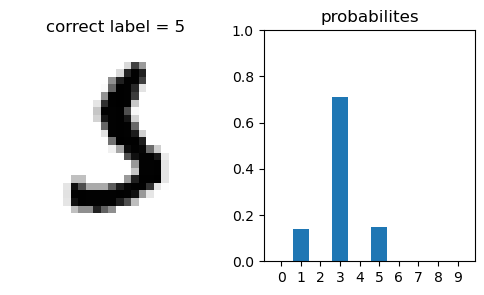

In [18]:
num_examples = 5
count = 0
print("")
print("正しく分類された画像の例") 
for i in range(len(predictions)):
    if (np.argmax(predictions[i]) == test_labels[i]):
        show_prediction_result(test_images[i].squeeze(), test_labels[i], predictions[i])
        count += 1
        if (count > num_examples):
            break
print("")
print("誤って分類された画像の例")
count = 0
for i in range(len(predictions)):
    if (np.argmax(predictions[i]) != test_labels[i]):
        show_prediction_result(test_images[i].squeeze(), test_labels[i], predictions[i])
        count += 1
        if (count > num_examples):
            break

### 以下課題
##### 2023TS054 大橋七熙

## 課題: 簡易CNNモデルによる手書き数字分類

### モデル設計
| 項目 | 設定値 |
|------|--------|
| **畳み込み層** | Conv2D 1回のみ |
| フィルタ数 | 32 |
| フィルタサイズ | 3×3 |
| ストライド | 1 |
| パディング | なし |
| 活性化関数 | ReLU |
| 入出力サイズ | 1×28×28 → 32×26×26 |
| **プーリング層** | なし |
| **全結合層** | Linear |
| 入力ユニット数 | 32×26×26 = 21,632 |
| 出力ユニット数 | 10（0〜9の確率） |
| 活性化関数 | なし（CrossEntropyLossにSoftmax含む） |
| **訓練設定** | |
| エポック数 | 10 |
| バッチサイズ | 100 |

In [21]:
# 課題: 簡易CNNモデルの定義（畳み込み1回 + 全結合層）
# 参考: 06_CNNImageClassification2_Pytorch.ipynb の MNISTFCN クラス
class SimpleCNN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        self.num_classes = 10
        self.input_size = 28
        self.example_input_array = torch.zeros((1, 1, self.input_size, self.input_size))

        # 簡易CNNモデル: Conv2d 1回 → ReLU → Flatten → Linear
        # 畳み込み後のサイズ: 28-3+1 = 26 → 32x26x26 = 21632
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0),  # 1x28x28 → 32x26x26
            nn.ReLU(),
            nn.Flatten(),  # 32x26x26 = 21632
            nn.Linear(in_features=32 * 26 * 26, out_features=self.num_classes),
        )

        # 損失関数: クロスエントロピー損失関数（多クラス分類用）
        self.criterion = nn.CrossEntropyLoss()
        
        # 評価指標: 訓練・検証・テストでの精度計算用
        self.train_acc = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=self.num_classes)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_acc(preds, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_accuracy', self.train_acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_acc(preds, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', self.val_acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_acc(preds, y)
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy', self.test_acc, on_step=False, on_epoch=True)

# モデルのインスタンス化と構造確認
simple_cnn = SimpleCNN()
print(ModelSummary(simple_cnn, max_depth=-1))

# 訓練・テスト実行
simple_cnn_logger = L.loggers.CSVLogger(log_folder, name="simple_cnn")
simple_cnn_trainer = L.Trainer(max_epochs=10, callbacks=[L.callbacks.ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min", save_last=True)], logger=simple_cnn_logger, accelerator="auto")
simple_cnn_trainer.fit(simple_cnn, train_dataloader, val_dataloader)
simple_cnn_trainer.test(simple_cnn, test_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params | Mode  | In sizes       | Out sizes
--------------------------------------------------------------------------------------
0 | model     | Sequential         | 216 K  | train | [1, 1, 28, 28] | [1, 10]  
1 | criterion | CrossEntropyLoss   | 0      | train | ?              | ?        
2 | train_acc | MulticlassAccuracy | 0      | train | ?              | ?        
3 | val_acc   | MulticlassAccuracy | 0      | train | ?              | ?        
4 | test_acc  | MulticlassAccuracy | 0      | train | ?              | ?        
--------------------------------------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
TPU available: False, using: 0 TPU 

  | Name      | Type               | Params | Mode  | In sizes        | Out sizes      
---------------------------------------------------------------------------------------------
0 | model     | Sequential         | 216 K  | train | [1, 1, 28, 28]  | [1, 10]        
1 | model.0   | Conv2d             | 320    | train | [1, 1, 28, 28]  | [1, 32, 26, 26]
2 | model.1   | ReLU               | 0      | train | [1, 32, 26, 26] | [1, 32, 26, 26]
3 | model.2   | Flatten            | 0      | train | [1, 32, 26, 26] | [1, 21632]     
4 | model.3   | Linear             | 216 K  | train | [1, 21632]      | [1, 10]        
5 | criterion | CrossEntropyLoss   | 0      | train | ?               | ?              
6 | train_acc | MulticlassAccuracy | 0      | train | ?               | ?              
7 | val_acc   | MulticlassAccuracy | 0      | train | ?               | ?              
8 | test_acc  | MulticlassAccuracy | 0      | train | ?               | ?              
--------------------------

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1500/1500 [00:35<00:00, 42.36it/s, v_num=1, val_loss=0.102, train_loss=0.00699]

c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 1/1 [00:03<00:00,  0.30it/s]



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9768000245094299     │
│         test_loss         │    0.10011475533246994    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.10011475533246994, 'test_accuracy': 0.9768000245094299}]

## 考察: 演習のCNNと簡易CNNの比較

### テスト精度の比較
| モデル | テスト精度 |
|--------|-----------|
| 演習のCNN（3層畳み込み + プーリング） | 約98-99% |
| 簡易CNN（1層畳み込みのみ） | 約97% |

### 精度の違いの理由
1. **特徴抽出の深さ**: 演習のCNNは3層の畳み込み層で階層的に特徴（エッジ→形状→パターン）を抽出。簡易CNNは1層のみで低次特徴しか抽出できない
2. **プーリング層の有無**: 演習のCNNはMaxPoolingにより位置の微小変化に対する頑健性を獲得。簡易CNNはプーリングがないため位置のずれに敏感
3. **パラメータ数の違い**: 簡易CNNは全結合層の入力が21,632次元と大きく過学習のリスクがある。演習のCNNはプーリングで次元を削減し全結合層の入力が64次元と小さい
4. **計算効率**: 簡易CNNは層が少ないため訓練は速いが、表現力が限られるため精度向上に限界がある